# [Optional] Data Preparation

---
This section is **optional**. For the purpose of making this lab as efficient as possible, data sets have already been prepared for you in MXNet [RecordIO format](https://mxnet.incubator.apache.org/versions/master/faq/recordio.html), which has various benefits including performance enhancement. The following are steps that were taken to produce training and validation samples in RecordIO format. Take note of the utility functions that MXNet provides for format conversion as well as the native data loaders. These are great features that reduce data wrangling work, and aren't provided by most frameworks.

## Download and unpack the dataset

---
In this exercise, we'll use the [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset, which contains 11,788 images across 200 bird species (the original technical report can be found [here](http://www.vision.caltech.edu/visipedia/papers/CUB_200_2011.pdf)).  Each species comes with around 60 images, with a typical size of about 350 pixels by 500 pixels.  Bounding boxes are provided, as are annotations of bird parts.  A recommended train/test split is given, but image size data is not.

![](./cub_200_2011_snapshot.png)

The dataset can be downloaded [here](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html).
Here we download the birds dataset from CalTech.

## Setup

Before preparing the data, there are some initial steps required for setup.


This notebook requires two additional Python packages:
* **OpenCV** is required for gathering image sizes and flipping of images horizontally.
* The **MXNet** runtime is required for using the im2rec tool.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install mxnet

In [3]:
import os 
import urllib.request

def download(url):
    filename = url.split('/')[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

In [4]:
%%time
download('http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz')

CPU times: user 1.47 s, sys: 2.46 s, total: 3.93 s
Wall time: 18.6 s


Now we unpack the dataset into its own directory structure.

In [8]:
%%time
# Clean up prior version of the downloaded dataset if you are running this again
!rm -rf CUB_200_2011  

# Unpack and then remove the downloaded compressed tar file
!gunzip -c ./CUB_200_2011.tgz | tar xopf - 
!rm CUB_200_2011.tgz

CPU times: user 62.7 ms, sys: 16.5 ms, total: 79.2 ms
Wall time: 7.15 s


# Understand the dataset

Here we define a few parameters that effect the sampling of the CalTech Birds dataset.  For example, `SAMPLE_ONLY` is defaulted to `True`. This will force the notebook to train on only a handful of species.  Setting to false will make the notebook work with the entire dataset of 200 bird species.  This makes the training a more difficult challenge, and you will need many more epochs to complete.

The file parameters define names and locations of metadata files for the dataset.

The RecordIO dataset that has been pre-processed for you utilize the default parameters laid out in the cell below.

In [5]:
import pandas as pd
import cv2
import boto3
import json

runtime = boto3.client(service_name='runtime.sagemaker')

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SPLIT = False
SAMPLE_ONLY  = True
FLIP         = False

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
CLASSES = [17, 36, 47, 68, 73]

# Otherwise, you can use the full set of species
if (not SAMPLE_ONLY):
    CLASSES = []
    for c in range(200):
        CLASSES += [c + 1]

RESIZE_SIZE = 256

BASE_DIR   = 'CUB_200_2011/'
IMAGES_DIR = BASE_DIR + 'images/'

CLASSES_FILE = BASE_DIR + 'classes.txt'
BBOX_FILE    = BASE_DIR + 'bounding_boxes.txt'
IMAGE_FILE   = BASE_DIR + 'images.txt'
LABEL_FILE   = BASE_DIR + 'image_class_labels.txt'
SIZE_FILE    = BASE_DIR + 'sizes.txt'
SPLIT_FILE   = BASE_DIR + 'train_test_split.txt'

TRAIN_LST_FILE = 'birds_ssd_train.lst'
VAL_LST_FILE   = 'birds_ssd_val.lst'

if (SAMPLE_ONLY):
    TRAIN_LST_FILE = 'birds_ssd_sample_train.lst'
    VAL_LST_FILE   = 'birds_ssd_sample_val.lst'

TRAIN_RATIO     = 0.8
CLASS_COLS      = ['class_number','class_id']
IM2REC_SSD_COLS = ['header_cols', 'label_width', 'zero_based_id', 'xmin', 'ymin', 'xmax', 'ymax', 'image_file_name']

## Explore the dataset images

For each species, there are dozens of images of various shapes and sizes. By dividing the entire dataset into individual named (numbered) folders, the images are in effect labelled for supervised learning using image classification and object detection algorithms. 

The following function displays a grid of thumbnail images for all the image files for a given species.

In [6]:
def show_species(species_id):
    _im_list = !ls $IMAGES_DIR/$species_id

    NUM_COLS = 6
    IM_COUNT = len(_im_list)

    print('Species ' + species_id + ' has ' + str(IM_COUNT) + ' images.')
    
    NUM_ROWS = int(IM_COUNT / NUM_COLS)
    if ((IM_COUNT % NUM_COLS) > 0):
        NUM_ROWS += 1

    fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS)
    fig.set_size_inches(8.0, 16.0, forward=True)

    curr_row = 0
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        f = IMAGES_DIR + species_id + '/' + _im_list[curr_img]
        a = plt.imread(f)

        # find the column by taking the current index modulo 3
        col = curr_img % NUM_ROWS
        # plot on relevant subplot
        axarr[col, curr_row].imshow(a)
        if col == (NUM_ROWS - 1):
            # we have finished the current row, so increment row counter
            curr_row += 1

    fig.tight_layout()       
    plt.show()
        
    # Clean up
    plt.clf()
    plt.cla()
    plt.close()

Show the list of bird species or dataset classes.

In [9]:
classes_df = pd.read_csv(CLASSES_FILE, sep=' ', names=CLASS_COLS, header=None)
criteria = classes_df['class_number'].isin(CLASSES)
classes_df = classes_df[criteria]
print(classes_df.to_csv(columns=['class_id'], sep='\t', index=False, header=False))

017.Cardinal
036.Northern_Flicker
047.American_Goldfinch
068.Ruby_throated_Hummingbird
073.Blue_Jay



Now for any given species, display thumbnail images of each of the images provided for training and testing.

Species 017.Cardinal has 57 images.


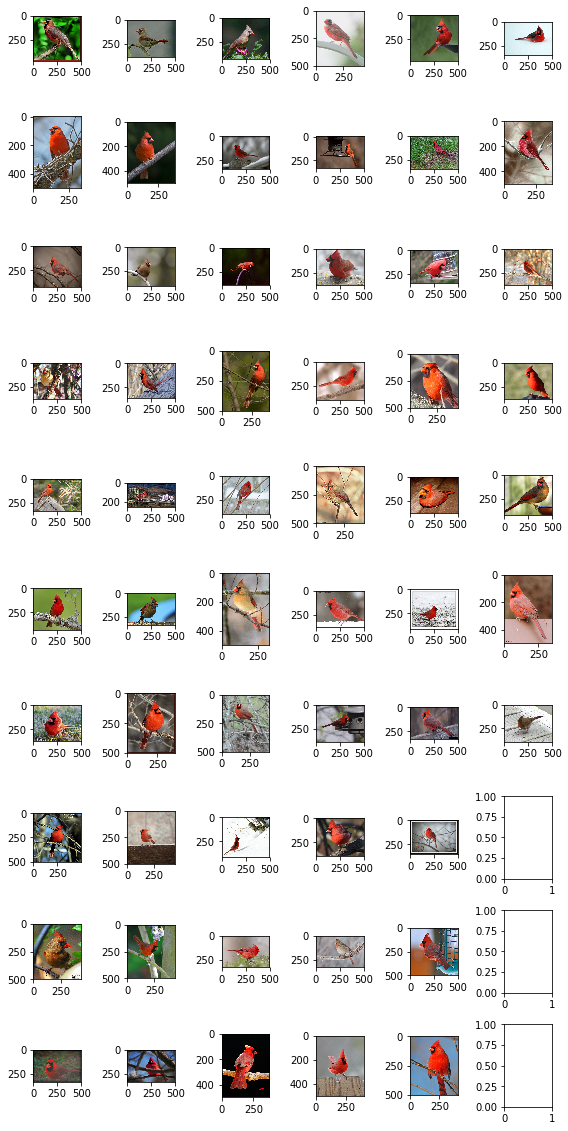

In [10]:
show_species('017.Cardinal')

# Generate RecordIO files

In this section we continue on with the **optional** data preparation exercise. This section serves as a good example of how to converate raw images into optimized RecordIO files.

## Step 1. Gather image sizes

For this particular dataset, bounding box annotations are specified in absolute terms.  RecordIO format requires them to be defined in terms relative to the image size.  The following code visits each image, extracts the height and width, and saves this information into a file for subsequent use.  Some other publicly available datasets provide such a file for exactly this purpose. 

In [11]:
%%time
SIZE_COLS = ['idx','width','height']

def gen_image_size_file():
    print('Generating a file containing image sizes...')
    images_df = pd.read_csv(IMAGE_FILE, sep=' ',
                            names=['image_pretty_name', 'image_file_name'],
                            header=None)
    rows_list = []
    idx = 0
    for i in images_df['image_file_name']:
        # TODO: add progress bar
        idx += 1
        img = cv2.imread(IMAGES_DIR + i)
        dimensions = img.shape
        height = img.shape[0]
        width = img.shape[1]
        image_dict = {'idx': idx, 'width': width, 'height': height}
        rows_list.append(image_dict)

    sizes_df = pd.DataFrame(rows_list)
    print('Image sizes:\n' + str(sizes_df.head()))

    sizes_df[SIZE_COLS].to_csv(SIZE_FILE, sep=' ', index=False, header=None)

gen_image_size_file()

Generating a file containing image sizes...
Image sizes:
   height  idx  width
0     335    1    500
1     336    2    500
2     347    3    500
3     500    4    415
4     380    5    331
CPU times: user 28.8 s, sys: 610 ms, total: 29.4 s
Wall time: 29.4 s


## Step 2. Generate list files for producing RecordIO files 

[RecordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) files can be created using the [im2rec tool](https://mxnet.incubator.apache.org/faq/recordio.html) (images to RecordIO), which takes as input a pair of list files, one for training images and the other for validation images.  Each list file has one row for each image.  For object detection, each row must contain bounding box data and a class label.

For the CalTech birds dataset, we need to convert absolute bounding box dimensions to relative dimensions based on image size.  We also need to adjust class id's to be zero-based (instead of 1 to 200, they need to be 0 to 199).  This  dataset comes with recommended train/test split information ("is_training_image" flag).  This notebook is built flexibly to either leverage this suggestion, or to create a random train/test split with a specific train/test ratio.  The `RAMDOM_SPLIT` variable defined earlier controls whether or not the split happens randomly.

In [12]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print('\n{}:\n---------\ntotal:{}\ntrain_df:{}\ntest_df:{}'.format(lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)))
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)
    return train_df, test_df

def gen_list_files():
    # use generated sizes file
    sizes_df = pd.read_csv(SIZE_FILE, sep=' ',
                names=['image_pretty_name', 'width', 'height'],
                header=None)
    bboxes_df = pd.read_csv(BBOX_FILE, sep=' ',
                names=['image_pretty_name', 'x_abs', 'y_abs', 'bbox_width', 'bbox_height'],
                header=None)
    split_df = pd.read_csv(SPLIT_FILE, sep=' ',
                            names=['image_pretty_name', 'is_training_image'],
                            header=None)
    print(IMAGE_FILE)
    images_df = pd.read_csv(IMAGE_FILE, sep=' ',
                            names=['image_pretty_name', 'image_file_name'],
                            header=None)
    print('num images total: ' + str(images_df.shape[0]))
    image_class_labels_df = pd.read_csv(LABEL_FILE, sep=' ',
                                names=['image_pretty_name', 'class_id'], header=None)

    # Merge the metadata into a single flat dataframe for easier processing
    full_df = pd.DataFrame(images_df)
    full_df.reset_index(inplace=True)
    full_df = pd.merge(full_df, image_class_labels_df, on='image_pretty_name')
    full_df = pd.merge(full_df, sizes_df, on='image_pretty_name')
    full_df = pd.merge(full_df, bboxes_df, on='image_pretty_name')
    full_df = pd.merge(full_df, split_df, on='image_pretty_name')
    full_df.sort_values(by=['index'], inplace=True)

    # Define the bounding boxes in the format required by SageMaker's built in Object Detection algorithm.
    # the xmin/ymin/xmax/ymax parameters are specified as ratios to the total image pixel size
    full_df['header_cols'] = 2  # one col for the number of header cols, one for the label width
    full_df['label_width'] = 5  # number of cols for each label: class, xmin, ymin, xmax, ymax
    full_df['xmin'] = full_df['x_abs'] / full_df['width']
    full_df['xmax'] = (full_df['x_abs'] + full_df['bbox_width']) / full_df['width']
    full_df['ymin'] = full_df['y_abs'] / full_df['height']
    full_df['ymax'] = (full_df['y_abs'] + full_df['bbox_height']) / full_df['height']

    # object detection class id's must be zero based. map from
    # class_id's given by CUB to zero-based (1 is 0, and 200 is 199).

    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df['class_id'].isin(CLASSES)
        full_df = full_df[criteria]

    unique_classes = full_df['class_id'].drop_duplicates()
    sorted_unique_classes = sorted(unique_classes)

    id_to_zero = {}
    i = 0.0
    for c in sorted_unique_classes:
        id_to_zero[c] = i
        i += 1.0

    full_df['zero_based_id'] = full_df['class_id'].map(id_to_zero)

    full_df.reset_index(inplace=True)

    # use 4 decimal places, as it seems to be required by the Object Detection algorithm
    pd.set_option("display.precision", 4)

    train_df = []
    val_df = []

    if (RANDOM_SPLIT):
        # split into training and validation sets
        train_df, val_df = split_to_train_test(full_df, 'class_id', TRAIN_RATIO)

        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep='\t',
                float_format='%.4f', header=None)
        val_df[IM2REC_SSD_COLS].to_csv(  VAL_LST_FILE, sep='\t',
                float_format='%.4f', header=None)
    else:
        train_df = full_df[(full_df.is_training_image == 1)]
        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep='\t',
                float_format='%.4f', header=None)

        val_df = full_df[(full_df.is_training_image == 0)]
        val_df[IM2REC_SSD_COLS].to_csv(  VAL_LST_FILE, sep='\t',
                float_format='%.4f', header=None)
        
    print('num train: ' + str(train_df.shape[0]))
    print('num val: ' + str(val_df.shape[0]))
    return train_df, val_df

In [13]:
train_df, val_df = gen_list_files()

CUB_200_2011/images.txt
num images total: 11788
num train: 150
num val: 147


Here we take a look at a few records from the training list file to understand better what is being fed to the RecordIO files.

The first column is the image number or index.  The second column indicates that the label is made up of 2 columns (column 2 and column 3).  The third column specifies the label width of a single object. In our case, the value 5 indicates each image has 5 numbers to describe its label information: the class index, and the 4 bounding box coordinates. If there are multiple objects within one image, all the label information should be listed in one line. Our dataset contains only one bounding box per image.

The fourth column is the class label.  This identifies the bird species using a zero-based class id.  Columns 4 through 7 represent the bounding box for where the bird is found in this image.

The classes should be labeled with successive numbers and start with 0. The bounding box coordinates are ratios of its top-left (xmin, ymin) and bottom-right (xmax, ymax) corner indices to the overall image size. Note that the top-left corner of the entire image is the origin (0, 0). The last column specifies the relative path of the image file within the images directory.

In [14]:
!tail -3 $TRAIN_LST_FILE

291	2	5	4.0000	0.4080	0.1527	0.9880	0.8728	073.Blue_Jay/Blue_Jay_0048_62433.jpg
294	2	5	4.0000	0.2500	0.1455	0.8260	0.8303	073.Blue_Jay/Blue_Jay_0086_63394.jpg
296	2	5	4.0000	0.2960	0.5400	0.8160	0.8460	073.Blue_Jay/Blue_Jay_0074_63487.jpg


## Step 3. Convert data into RecordIO format

Now we create im2rec databases (.rec files) for training and validation based on the list files created earlier.

In [15]:
!python tools/im2rec.py --resize $RESIZE_SIZE --pack-label birds_ssd_sample $BASE_DIR/images/

Creating .rec file from /home/ec2-user/SageMaker/object_detection_birds_2019-05-15/birds_ssd_sample_val.lst in /home/ec2-user/SageMaker/object_detection_birds_2019-05-15
multiprocessing not available, fall back to single threaded encoding
time: 0.004897117614746094  count: 0
Creating .rec file from /home/ec2-user/SageMaker/object_detection_birds_2019-05-15/birds_ssd_sample_train.lst in /home/ec2-user/SageMaker/object_detection_birds_2019-05-15
multiprocessing not available, fall back to single threaded encoding
time: 0.0040090084075927734  count: 0


## Step 4. Upload RecordIO files to S3

Upload the training and validation data to the S3 bucket. We do this in multiple channels. Channels are simply directories in the bucket that differentiate the types of data provided to the algorithm. For the object detection algorithm, we call these directories `train` and `validation`.

In [18]:
# set the BUCKET to the name of your S3 bucket
#BUCKET = 'dtong-ml-datasets'
BUCKET = '<<REPLACE YOUR BUCKET NAME>>'
S3_PREFIX = 'datasets/caltech-birds/recordio'

In [24]:
import sagemaker
import boto3
import time

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

# Upload the RecordIO files to train and validation channels
train_channel = S3_PREFIX + '/train'
validation_channel = S3_PREFIX + '/validation'

start = time.time()
sess.upload_data(path='birds_ssd_sample_train.rec', bucket=BUCKET, key_prefix=train_channel)
sess.upload_data(path='birds_ssd_sample_val.rec', bucket=BUCKET, key_prefix=validation_channel)
end = time.time()

s3_train_data = 's3://{}/{}'.format(BUCKET, train_channel)
s3_validation_data = 's3://{}/{}'.format(BUCKET, validation_channel)

print('RecordIO files uploaded in {} seconds'.format(end-start))
print('Training dataset location: {}'.format(s3_train_data))
print('Validation dataset location: {}'.format(s3_validation_data))

RecordIO files uploaded in 2.363466739654541 seconds
Training dataset location: s3://dtong-ml-datasets/datasets/caltech-birds/recordio/train
Validation dataset location: s3://dtong-ml-datasets/datasets/caltech-birds/recordio/validation
